# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [9]:
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_model(audio_features, learning_rate=0.00005, num_classes=20):
    tf.keras.backend.clear_session()

    # Load EfficientNetB0 with ImageNet weights, excluding the top layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Input layer for the audio features
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]), name='Audio_Features')

    # Extract features using the base model
    features = base_model(inputs)

    # Add a global average pooling layer
    features = tf.keras.layers.GlobalAveragePooling2D()(features)

    # Add a custom fully connected (dense) layer
    features = tf.keras.layers.Dense(
        units=512,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        name='fc_1')(features)

    # Add dropout layer for regularization
    features = tf.keras.layers.Dropout(rate=0.3)(features)

    # Output layer with softmax activation
    outputs = tf.keras.layers.Dense(
        units=num_classes,
        activation='softmax',
        name='fc_output')(features)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='EfficientNet_Audio_Classification')

    print(model.summary())

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_EfficientNetB0.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs and Chroma

In [14]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [15]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [17]:
model = build_efficientnet_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "EfficientNet_Audio_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 4, 9, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,715,703 (17.99 MB)

 Trainable params: 666,132 (2.54 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 52s 178ms/step - accuracy: 0.1021 - loss: 9.6419 - val_accuracy: 0.1044 - val_loss: 7.9017
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1438 - loss: 7.4856 - val_accuracy: 0.1044 - val_loss: 6.2932
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1298 - loss: 6.0240 - val_accuracy: 0.1044 - val_loss: 5.1749
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.1417 - loss: 4.9866 - val_accuracy: 0.1044 - val_loss: 4.4027
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1275 - loss: 4.2836 - val_accuracy: 0.1044 - val_loss: 3.8779
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.1291 - loss: 3.8054 - val_accuracy: 0.1044 - val_loss: 3.5135
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1343 - loss: 3.4927 - val_accuracy: 0.1044 - val_loss: 3.2726
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1336 - loss: 3.2713 - v

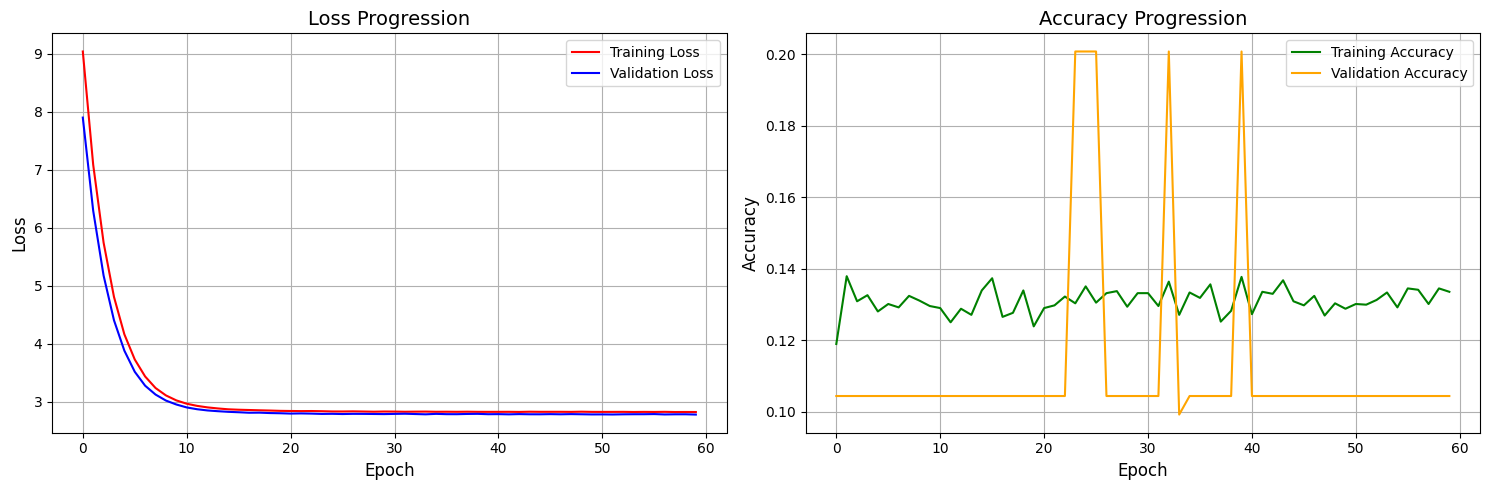

In [18]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [19]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.1301 - loss: 2.8095
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1061 - loss: 2.7729


In [20]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.10      1.00      0.19       141
           2       0.00      0.00      0.00       271
           3       0.00      0.00      0.00        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        54
          13       0.00      0.00      0.00        48
          14       0.00      0.00      0.00        38
          15       0.00      0.00      0.00       117
          16       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Mel Spectrogram and MFCCs

In [21]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [22]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [23]:
model = build_efficientnet_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "EfficientNet_Audio_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 4, 9, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,715,703 (17.99 MB)

 Trainable params: 666,132 (2.54 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.1242 - loss: 9.7229 - val_accuracy: 0.1696 - val_loss: 8.2880
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2178 - loss: 7.9417 - val_accuracy: 0.2437 - val_loss: 6.9606
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2899 - loss: 6.6687 - val_accuracy: 0.2837 - val_loss: 5.9814
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3221 - loss: 5.7395 - val_accuracy: 0.2889 - val_loss: 5.2275
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3331 - loss: 5.0559 - val_accuracy: 0.2956 - val_loss: 4.6558
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3620 - loss: 4.4979 - val_accuracy: 0.3578 - val_loss: 4.2134
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3530 - loss: 4.0814 - val_accuracy: 0.3370 - val_loss: 3.8762
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3796 - loss: 3.7430 - v

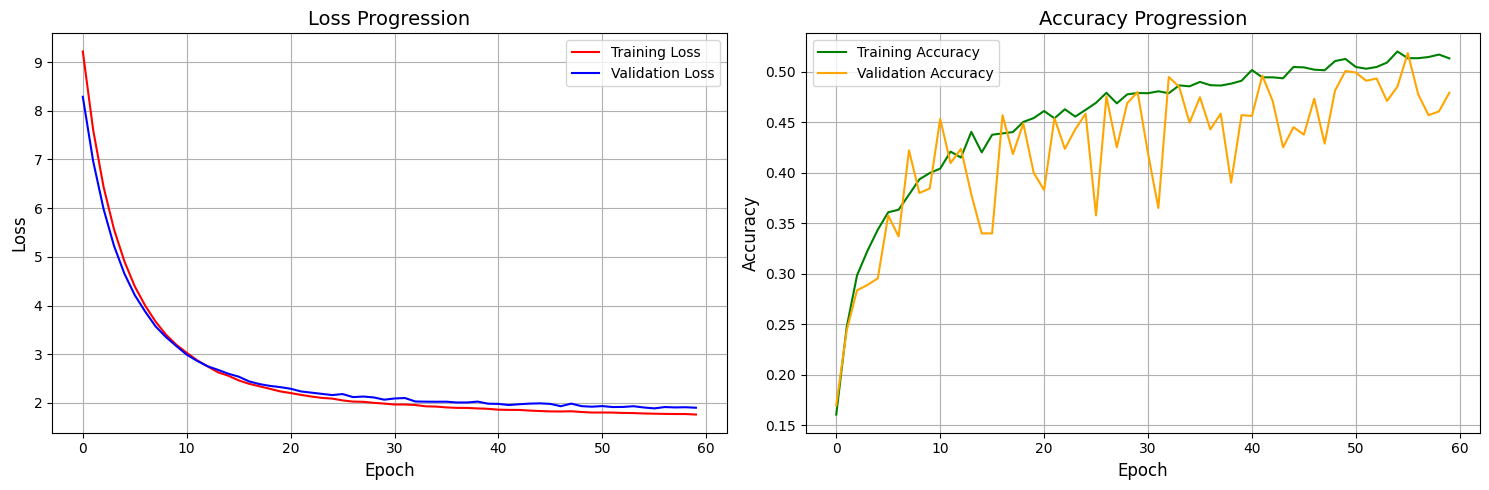

In [24]:
visualize(history, 'mfcc_melspectrogram')

In [25]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5801 - loss: 1.6342
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4820 - loss: 1.8753


In [26]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.76      0.42      0.54       114
           1       0.32      0.62      0.42       141
           2       0.78      0.74      0.76       271
           3       0.32      0.37      0.34        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        23
           7       0.86      1.00      0.93        44
           8       0.00      0.00      0.00        50
           9       0.68      0.51      0.58        49
          10       0.46      0.12      0.20        48
          11       0.23      0.07      0.10        46
          12       0.43      0.96      0.59        54
          13       0.26      0.29      0.27        48
          14       0.00      0.00      0.00        38
          15       0.56      0.23      0.33       117
          16       0.29      0.98      0.44   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Review all the results

In [27]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,melspectrogram_chroma_mfcc,0.134,0.104
1,mfcc_melspectrogram,0.576,0.479


In [28]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0  melspectrogram_chroma_mfcc     0.020      0.589
1         mfcc_melspectrogram     0.447      0.902
